In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from MulticoreTSNE import MulticoreTSNE

In [2]:
train = pd.read_csv('train.csv', index_col=0, parse_dates=['birthday', 'date'])
test = pd.read_csv('test.csv', index_col=0, parse_dates=['birthday', 'date'])

In [3]:
data = pd.concat([train, test])

In [4]:
data['service_lemm'] = data['service_lemm'].fillna('')

In [5]:
from ast import literal_eval

def target_mode(target):
    if target is np.nan:
        return target
    target = literal_eval(target)
    return sp.stats.mode(target)[0][0]

In [6]:
%%time

data['target'] = data['target'].apply(target_mode)

CPU times: user 6.97 s, sys: 9.47 ms, total: 6.97 s
Wall time: 6.98 s


In [7]:
num_cols = ['num', 'birthday_year']
cat_cols = ['service_class']
text_cols = ['service_lemm']

In [8]:
X_cols = num_cols + cat_cols + text_cols
X = data[X_cols]
y = data['target']

In [9]:
num_indices = np.argwhere(X.columns.isin(num_cols)).flatten()
cat_indices = np.argwhere(X.columns.isin(cat_cols)).flatten()
text_indices = np.argwhere(X.columns.isin(text_cols)).flatten()

In [10]:
fu = FeatureUnion([
    ('num', Pipeline([
        ('select', FunctionTransformer(lambda X: X[:, num_indices], validate=False)),
        ('scaler', StandardScaler())
    ])),
    ('cat', Pipeline([
        ('select', FunctionTransformer(lambda X: X[:, cat_indices], validate=False)),
        ('onehot', OneHotEncoder(sparse=False, categories='auto', handle_unknown='ignore'))
    ])),
    ('text', Pipeline([
        ('select', FunctionTransformer(lambda X: X[:, text_indices[0]], validate=False)),
        ('tfidf', TfidfVectorizer(min_df=50)),
        ('toarray', FunctionTransformer(lambda X: X.toarray(), validate=False, accept_sparse=True))
    ]))
])

In [11]:
X_transformed = fu.fit_transform(X.values, y.values)

In [12]:
X_transformed.shape

(165401, 1503)

In [13]:
tsne = MulticoreTSNE(random_state=42, n_jobs=-1)

In [14]:
X_tsne = tsne.fit_transform(X_transformed)

In [15]:
classes = y.sort_values().unique()
classes

array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M',
       'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y', 'Z', nan],
      dtype=object)

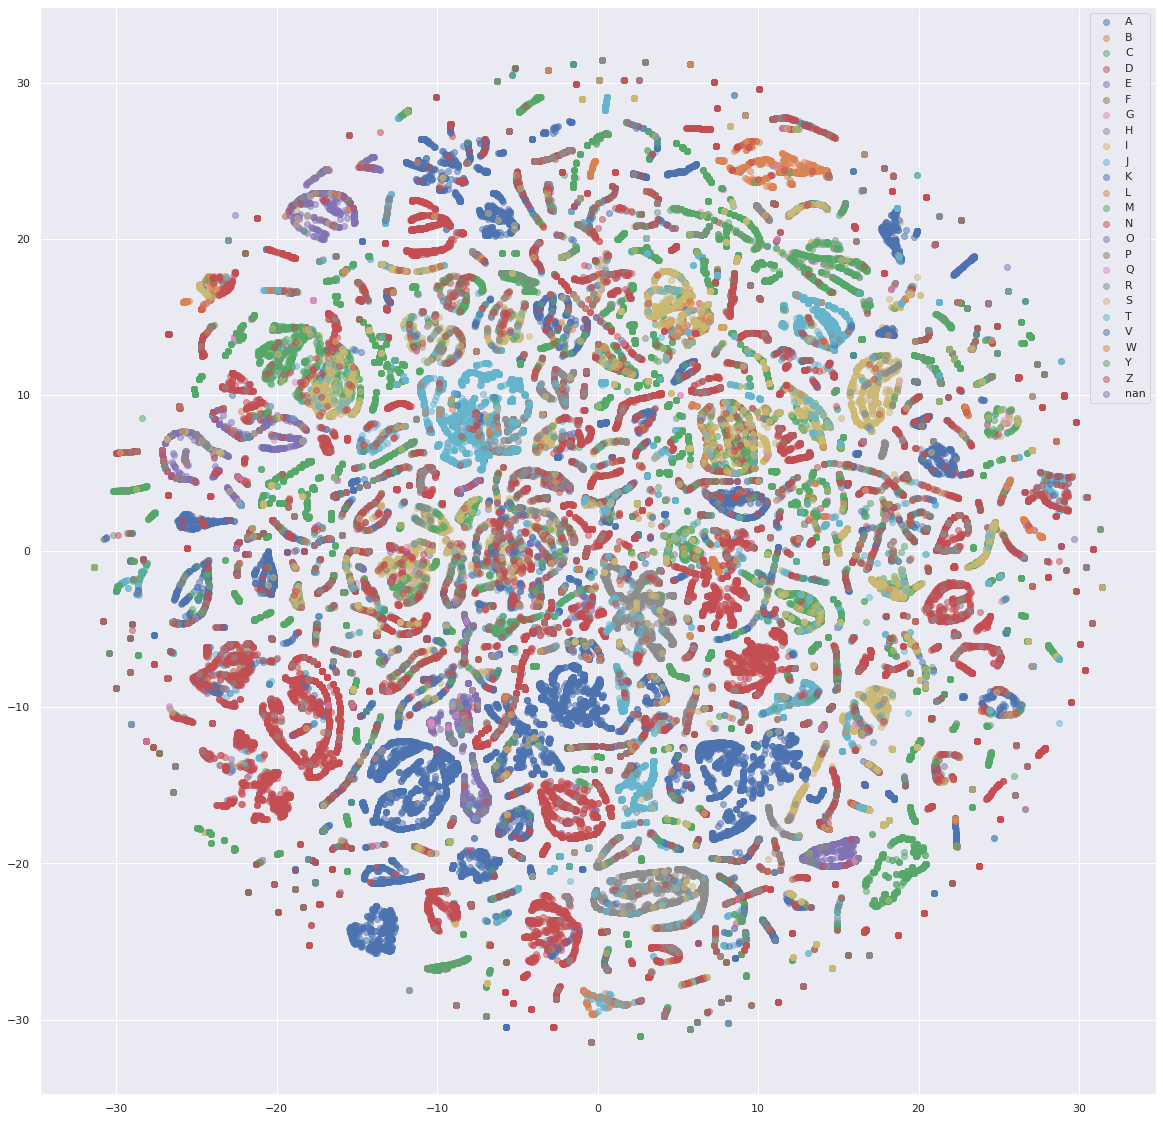

In [16]:
plt.figure(figsize=(20, 20))
for c in classes: 
    indices = np.argwhere(y.values == c)
    plt.scatter(X_tsne[indices, 0], X_tsne[indices, 1], alpha=0.5, label=c);
plt.legend();